## Image Classification using CNN

### (a) Dataloader

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision import transforms

In [2]:
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')

In [3]:
x_train.shape

(60000, 784)

Currently the data is flattened and we may need to convert it to a 2D array of 28x28 array.

In [4]:
# Reshape x_train to (60000, 1, 28, 28)
x_train = x_train.reshape(-1, 1, 28, 28)
 

Here 60000 is the total number of images, 1 is for channel dimension, and 28,28 is height and width of each image.

In [5]:
# Convert numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)  
y_train_tensor = torch.tensor(y_train, dtype=torch.long)    

In [6]:
# Create a TensorDataset and DataLoader
full_dataset = TensorDataset(x_train_tensor, y_train_tensor)
full_loader = DataLoader(full_dataset, batch_size=64, shuffle=True)

# Check DataLoader output
for img, label in full_loader:
    print(f"Batch of images shape: {img.shape}")  # Expected: (64, 1, 28, 28)
    print(f"Batch of labels shape: {label.shape}")  # Expected: (64,)
    break  # Display only the first batch


Batch of images shape: torch.Size([64, 1, 28, 28])
Batch of labels shape: torch.Size([64])


### (b) Data Exploration

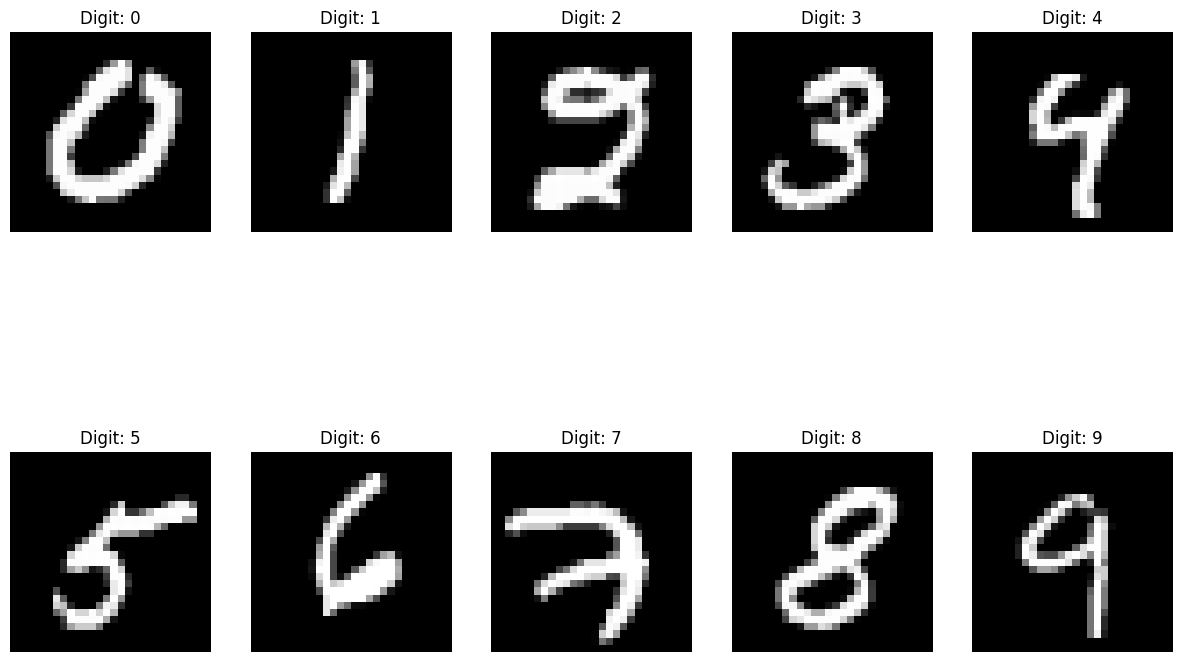

In [7]:
import matplotlib.pyplot as plt

# Pick one example from each digit and visualize them
unique_labels, counts = np.unique(y_train, return_counts=True)

fig , ax = plt.subplots(
    nrows=2,
    ncols=5,
    figsize=(15, 10))

ax = ax.ravel()

for i, label in enumerate(unique_labels):
    # Get the first index of each unique label
    idx = np.where(y_train == label)[0][0]
    ax[i].imshow(x_train[idx][0], cmap='gray')
    ax[i].set_title(f'Digit: {label}')
    ax[i].axis('off')
    


In [8]:
print("Number of sample per digit:")

for i in range(len(counts)):
    print(f"Digit {unique_labels[i]}: {counts[i]}")

Number of sample per digit:
Digit 0: 5923
Digit 1: 6742
Digit 2: 5958
Digit 3: 6131
Digit 4: 5842
Digit 5: 5421
Digit 6: 5918
Digit 7: 6265
Digit 8: 5851
Digit 9: 5949


### (c) Modelling

##### (1) Split the training data

In [9]:
# Split train_dataset into training and validation datasets

from torch.utils.data import random_split

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [10]:
### Defining class for CNN

import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, in_channels=1, n_hidden1=10, n_hidden2=20, kernel_size=5, stride=1, dropout_rate=0.5, padding=0,activation=F.relu):
        super(CNN, self).__init__()

        # Define convolutional layers
        self.conv1 = nn.Conv2d(in_channels, n_hidden1, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(n_hidden1, n_hidden2, kernel_size=kernel_size, stride=stride, padding=padding)
        
        # Define dropout layer
        self.conv2_drop = nn.Dropout2d(p=dropout_rate)

        # Calculate output size after each convolution and pooling layer
        # After conv1 + max pooling
        self.outpool1 = ((28 - kernel_size + 2 * padding) // stride + 1) // 2  # 28x28 -> pooled output size
        # After conv2 + max pooling
        self.outpool2 = ((self.outpool1 - kernel_size + 2 * padding) // stride + 1) // 2

        # Define fully connected layers based on flattened output from conv layers
        self.fc1 = nn.Linear(int(self.outpool2 * self.outpool2 * n_hidden2), 50)
        self.fc2 = nn.Linear(50, 10)

        self.n_hidden2 = n_hidden2
        self.activation = activation
    
    def forward(self, x):
        # Forward pass through conv layers and max pooling
        x = self.activation(F.max_pool2d(self.conv1(x), 2))
        x = self.activation(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # Flatten the output for the fully connected layer
        x = x.view(-1, int(self.outpool2 * self.outpool2 * self.n_hidden2))
        x = self.activation(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return x


Ref: https://github.com/dandiws/CNN-MNIST-pytorch/blob/master/cnn_mnist.py;

https://www.youtube.com/watch?v=vBlO87ZAiiw;

https://www.youtube.com/watch?v=pDdP0TFzsoQ;

https://www.youtube.com/watch?v=gBw0u_5u0qU&t=1292s

##### To train our model let's use cross entropy loss function first and use Adam and SGD optimizer. We will create two models and compare the two optimizers and then use one model for future.

##### Cross entropy loss function with Adam Optimizer

##### (3) Trainig model and computing accuracy

In [11]:

from tqdm import tqdm
import torch.optim as optim  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_adam = CNN().to(device)
optimizer = optim.Adam(model_adam.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

n_epochs = 50
train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

for epoch in tqdm(range(n_epochs)):
    # Training
    model_adam.train()
    epoch_train_loss = []
    correct_train = 0
    total_train = 0
    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        preds = model_adam(X)
        loss = loss_fn(preds, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss.append(loss.item())
        
        # Calculate accuracy
        predicted = preds.argmax(dim=1, keepdim=True)  
        correct_train += predicted.eq(y.view_as(predicted)).sum().item()
        total_train += y.size(0)

    train_loss.append(np.mean(epoch_train_loss))
    train_accuracy.append(correct_train / total_train)  # Training accuracy

    # Validation
    model_adam.eval()
    epoch_val_loss = []
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(val_loader):
            X, y = X.to(device), y.to(device)
            preds = model_adam(X)
            loss = loss_fn(preds, y)
            epoch_val_loss.append(loss.item())
            
            # Calculate accuracy
            predicted = preds.argmax(dim=1, keepdim=True)  
            correct_val += predicted.eq(y.view_as(predicted)).sum().item()
            total_val += y.size(0)

    val_loss.append(np.mean(epoch_val_loss))
    val_accuracy.append(correct_val / total_val)  # Validation accuracy

# Convert lists to numpy arrays if needed
train_loss_adam = np.array(train_loss)
val_loss_adam = np.array(val_loss)
train_accuracy_adam = np.array(train_accuracy)
val_accuracy_adam = np.array(val_accuracy)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:09<00:00,  2.60s/it]


Overall classification accuracy on validation dataset:0.99


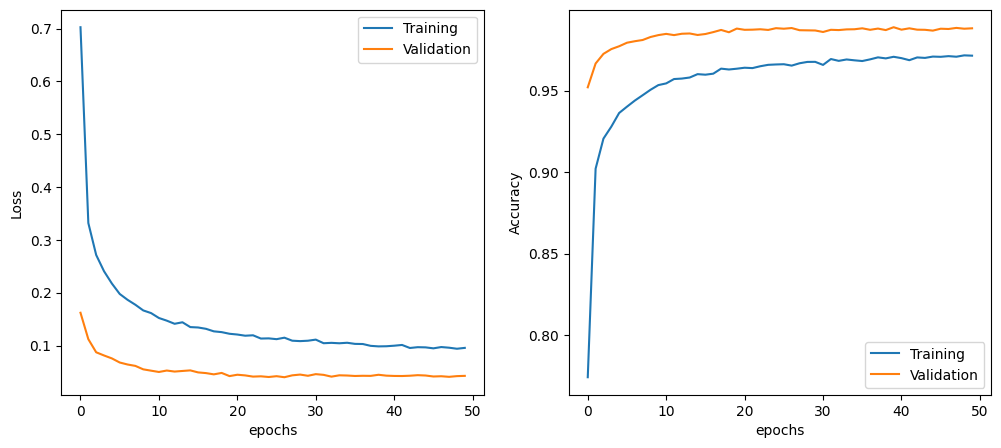

In [12]:
fig , ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 5))

ax[0].plot(np.arange(n_epochs),train_loss_adam,label='Training')
ax[0].plot(np.arange(n_epochs),val_loss_adam,label='Validation')
ax[0].legend()
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(np.arange(n_epochs),train_accuracy_adam,label='Training')
ax[1].plot(np.arange(n_epochs),val_accuracy_adam,label='Validation')
ax[1].legend()
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Accuracy')

print('Overall classification accuracy on validation dataset:%.2f'%val_accuracy_adam[-1])

Here for both training and validation set the loss appear to plateau with number of epochs, suggesting the current number of iteractions are good enough. 

One thing to notice is training loss appears high compared to validation loss. This could be due to the dropout rate use while training.

____________________________________
Ref: https://siddiqueabusaleh.medium.com/why-my-training-loss-is-higher-than-validation-loss-is-the-reported-loss-even-accurate-8843e14a0756#:~:text=Dropout:%20During%20training%2C%20the%20inclusion,this%20can%20be%20expressed%20as:

Dropout: During training, the inclusion of dropout means that a certain percentage of neurons are randomly disabled. This effectively creates a different, “thinned” network at each training step. The loss calculated during these steps reflects the performance of a network under these regularization conditions, the displayed loss is generally higher because the network isn’t leveraging its full capacity.

When the model is in test mode, dropout is not applied. The network uses all its neurons, thus operating at full capacity. This typically results in a lower loss and higher accuracy compared to those reported during training epochs, as the network can now leverage all available resources and information.

##### Cross entropy loss function with SGD Optimizer

In [13]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_sgd = CNN().to(device)
optimizer = optim.SGD(model_sgd.parameters(), lr=0.001,momentum=0.01)
loss_fn = nn.CrossEntropyLoss()

n_epochs = 50
train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

for epoch in tqdm(range(n_epochs)):
    # Training
    model_sgd.train()
    epoch_train_loss = []
    correct_train = 0
    total_train = 0
    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        preds = model_sgd(X)
        loss = loss_fn(preds, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss.append(loss.item())
        
        # Calculate accuracy
        predicted = preds.argmax(dim=1, keepdim=True)  
        correct_train += predicted.eq(y.view_as(predicted)).sum().item()
        total_train += y.size(0)

    train_loss.append(np.mean(epoch_train_loss))
    train_accuracy.append(correct_train / total_train)  # Training accuracy

    # Validation
    model_sgd.eval()
    epoch_val_loss = []
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(val_loader):
            X, y = X.to(device), y.to(device)
            preds = model_sgd(X)
            loss = loss_fn(preds, y)
            epoch_val_loss.append(loss.item())
            
            # Calculate accuracy
            predicted = preds.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct_val += predicted.eq(y.view_as(predicted)).sum().item()
            total_val += y.size(0)

    val_loss.append(np.mean(epoch_val_loss))
    val_accuracy.append(correct_val / total_val)  # Validation accuracy

# Convert lists to numpy arrays if needed
train_loss_sgd = np.array(train_loss)
val_loss_sgd = np.array(val_loss)
train_accuracy_sgd = np.array(train_accuracy)
val_accuracy_sgd = np.array(val_accuracy)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:01<00:00,  2.42s/it]


Overall classification accuracy on validation dataset:0.94


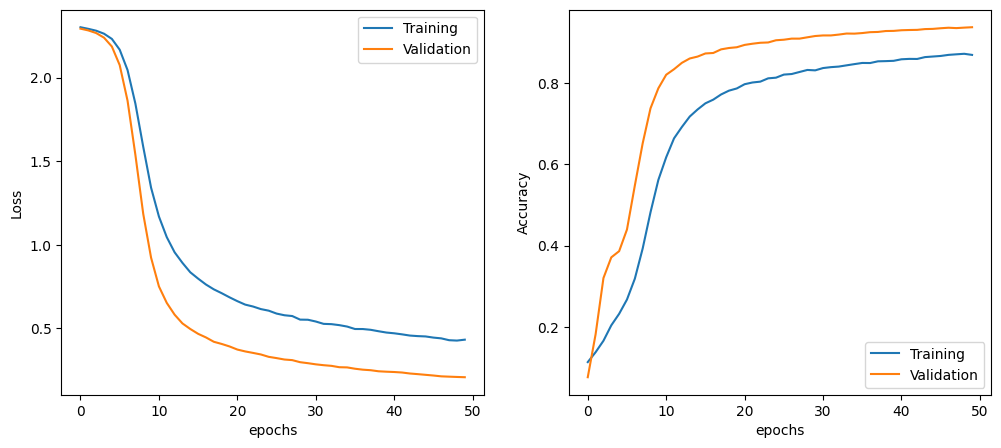

In [15]:
fig , ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 5))

ax[0].plot(np.arange(n_epochs),train_loss_sgd,label='Training')
ax[0].plot(np.arange(n_epochs),val_loss_sgd,label='Validation')
ax[0].legend()
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(np.arange(n_epochs),train_accuracy_sgd,label='Training')
ax[1].plot(np.arange(n_epochs),val_accuracy_sgd,label='Validation')
ax[1].legend()
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Accuracy')

print('Overall classification accuracy on validation dataset:%.2f'%val_accuracy_sgd[-1])

From the above comparisons it seems like Adam optimizer is going a better job compared to SGD. I will continue with Adam optimizer model.

##### (2) Visualizing filters in each layer for model with adam optimizer

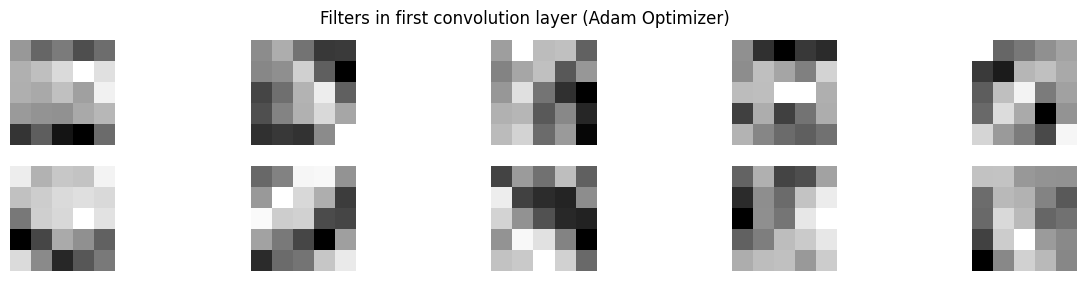

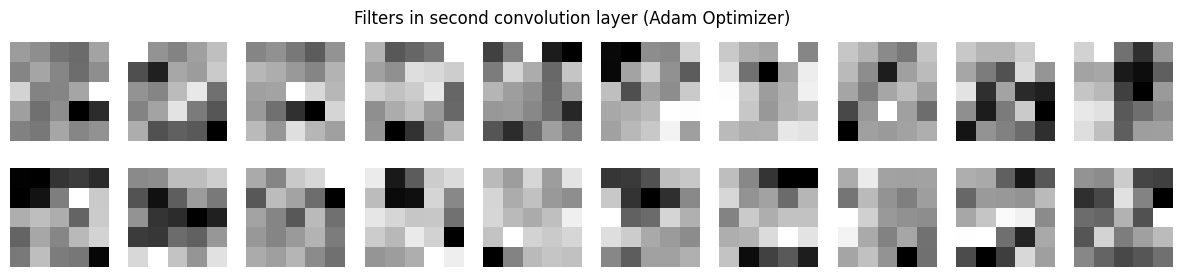

Overall classification accuracy on validation dataset:0.99


In [16]:
# Access the filters for the first conv layer in model_adam
filters = model_adam.conv1.weight.data.cpu().numpy()
fig, axes = plt.subplots(2, int(len(filters)/2), figsize=(15, 3))
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.imshow(filters[i, 0, :, :], cmap='gray')  # Assuming grayscale filters
    ax.axis('off')
plt.suptitle('Filters in first convolution layer (Adam Optimizer)')
plt.show()

# Access the filters for the second conv layer in model_adam
filters = model_adam.conv2.weight.data.cpu().numpy()

fig, axes = plt.subplots(2, int(len(filters)/2), figsize=(15, 3))
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.imshow(filters[i, 0, :, :], cmap='gray')  # Assuming grayscale filters
    ax.axis('off')
plt.suptitle('Filters in second convolution layer (Adam Optimizer)')
plt.show()

print('Overall classification accuracy on validation dataset:%.2f'%val_accuracy_adam[-1])

##### (4) Testing hyperparameters

##### Here I will be tuning number of filters in first and second convolution layers, kernel size, dropout rate, learning rate of optimizer, weight regularization of optimizer, and activation function. I will tune it one at a time. First let's test number of filters in first and second conv layer.

In [20]:
### Tuning number of filters

# Hyperparameters
hyperparameters= {
    'n_hidden1': [5,10,15],       # Number of filters in first conv layer
    'n_hidden2': [15,20,25],      # Number of filters in second conv layer
    'kernel_size': [5],          # Kernel size for conv layers
    'dropout_rate': [0.5],     # Dropout rate
    'lr': [ 0.001],          # Learning rate
    'weight_decay': [0],       # Weight regularization (L2 penalty)
    'acitvation':[F.relu]     #activation
}

# Results dictionary 
results = {}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for n_hidden1 in hyperparameters['n_hidden1']:
    for n_hidden2 in hyperparameters['n_hidden2']:
        for kernel_size in hyperparameters['kernel_size']:
            for dropout_rate in hyperparameters['dropout_rate']:
                for lr in hyperparameters['lr']:
                    for weight_decay in hyperparameters['weight_decay']:
                        for activation in hyperparameters['acitvation']:
                            print('n_hidden1:',n_hidden1,'n_hidden2:',n_hidden2,'kernel_size:',kernel_size,'dropout_rate:',dropout_rate,'lr:',lr,'weight_decay:',weight_decay,'activation:',activation)
                            
                            # Define model with the current set of hyperparameters
                            model = CNN(
                                in_channels=1,
                                n_hidden1=n_hidden1,
                                n_hidden2=n_hidden2,
                                kernel_size=kernel_size,
                                dropout_rate=dropout_rate,
                                activation=activation
                            ).to(device)
                            
                            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
                            loss_fn = nn.CrossEntropyLoss()
                            n_epochs = 10  
                            val_loss = []
                            val_accuracy = []

                            for epoch in range(n_epochs):
                                
                                # Training
                                model.train()
                                for batch, (X, y) in enumerate(train_loader):
                                    X, y = X.to(device), y.to(device)
                                    optimizer.zero_grad()
                                    preds = model(X)
                                    loss = loss_fn(preds, y)
                                    loss.backward()
                                    optimizer.step()

                                # Validation
                                model.eval()
                                correct_val = 0
                                total_val = 0
                                epoch_val_loss = []
                                with torch.no_grad():
                                    for batch, (X, y) in enumerate(val_loader):
                                        X, y = X.to(device), y.to(device)
                                        preds = model(X)
                                        loss = loss_fn(preds, y)
                                        epoch_val_loss.append(loss.item())
                                        
                                        # Calculate accuracy
                                        predicted = preds.argmax(dim=1, keepdim=True)  
                                        correct_val += predicted.eq(y.view_as(predicted)).sum().item()
                                        total_val += y.size(0)

                                val_loss.append(np.mean(epoch_val_loss))
                                val_accuracy.append(correct_val / total_val)

                            print('Validation Accuracy:',val_accuracy[-1])
                            # Store results for this hyperparameter combination
                            results[(n_hidden1, n_hidden2, kernel_size, dropout_rate, lr, weight_decay,activation)] = {
                                'val_loss': val_loss[-1],
                                'val_accuracy': val_accuracy[-1]
                            }

print('#########################################################')
# Find the best hyperparameter combination based on validation accuracy
best_hyperparams = max(results, key=lambda x: results[x]['val_accuracy'])
best_results = results[best_hyperparams]

print("Best Hyperparameters:", best_hyperparams)
print("Validation Accuracy with Best Hyperparameters:", best_results['val_accuracy'])

n_hidden1: 5 n_hidden2: 15 kernel_size: 5 dropout_rate: 0.5 lr: 0.001 weight_decay: 0 activation: <function relu at 0x75fc7545a430>
Validation Accuracy: 0.97725
n_hidden1: 5 n_hidden2: 20 kernel_size: 5 dropout_rate: 0.5 lr: 0.001 weight_decay: 0 activation: <function relu at 0x75fc7545a430>
Validation Accuracy: 0.98175
n_hidden1: 5 n_hidden2: 25 kernel_size: 5 dropout_rate: 0.5 lr: 0.001 weight_decay: 0 activation: <function relu at 0x75fc7545a430>
Validation Accuracy: 0.9836666666666667
n_hidden1: 10 n_hidden2: 15 kernel_size: 5 dropout_rate: 0.5 lr: 0.001 weight_decay: 0 activation: <function relu at 0x75fc7545a430>
Validation Accuracy: 0.9783333333333334
n_hidden1: 10 n_hidden2: 20 kernel_size: 5 dropout_rate: 0.5 lr: 0.001 weight_decay: 0 activation: <function relu at 0x75fc7545a430>
Validation Accuracy: 0.9840833333333333
n_hidden1: 10 n_hidden2: 25 kernel_size: 5 dropout_rate: 0.5 lr: 0.001 weight_decay: 0 activation: <function relu at 0x75fc7545a430>
Validation Accuracy: 0.9845

From the above the best number of filters in first and second convolution are 15 and 25 respectively. Let's use this and tune other hyper parameters. Let's tune kernel size now.

In [21]:
## Tuning Kernel size

# Hyperparameters
hyperparameters= {
    'n_hidden1': [15],       # Number of filters in first conv layer
    'n_hidden2': [25],      # Number of filters in second conv layer
    'kernel_size': [2,3,5],          # Kernel size for conv layers
    'dropout_rate': [0.5],     # Dropout rate
    'lr': [ 0.001],          # Learning rate
    'weight_decay': [0],       # Weight regularization (L2 penalty)
    'acitvation':[F.relu]     #activation
}

# Results dictionary 
results = {}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for n_hidden1 in hyperparameters['n_hidden1']:
    for n_hidden2 in hyperparameters['n_hidden2']:
        for kernel_size in hyperparameters['kernel_size']:
            for dropout_rate in hyperparameters['dropout_rate']:
                for lr in hyperparameters['lr']:
                    for weight_decay in hyperparameters['weight_decay']:
                        for activation in hyperparameters['acitvation']:
                            print('n_hidden1:',n_hidden1,'n_hidden2:',n_hidden2,'kernel_size:',kernel_size,'dropout_rate:',dropout_rate,'lr:',lr,'weight_decay:',weight_decay,'activation:',activation)
                            
                            # Define model with the current set of hyperparameters
                            model = CNN(
                                in_channels=1,
                                n_hidden1=n_hidden1,
                                n_hidden2=n_hidden2,
                                kernel_size=kernel_size,
                                dropout_rate=dropout_rate,
                                activation=activation
                            ).to(device)
                            
                            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
                            loss_fn = nn.CrossEntropyLoss()
                            n_epochs = 10  
                            val_loss = []
                            val_accuracy = []

                            for epoch in range(n_epochs):
                                
                                # Training
                                model.train()
                                for batch, (X, y) in enumerate(train_loader):
                                    X, y = X.to(device), y.to(device)
                                    optimizer.zero_grad()
                                    preds = model(X)
                                    loss = loss_fn(preds, y)
                                    loss.backward()
                                    optimizer.step()

                                # Validation
                                model.eval()
                                correct_val = 0
                                total_val = 0
                                epoch_val_loss = []
                                with torch.no_grad():
                                    for batch, (X, y) in enumerate(val_loader):
                                        X, y = X.to(device), y.to(device)
                                        preds = model(X)
                                        loss = loss_fn(preds, y)
                                        epoch_val_loss.append(loss.item())
                                        
                                        # Calculate accuracy
                                        predicted = preds.argmax(dim=1, keepdim=True) 
                                        correct_val += predicted.eq(y.view_as(predicted)).sum().item()
                                        total_val += y.size(0)

                                val_loss.append(np.mean(epoch_val_loss))
                                val_accuracy.append(correct_val / total_val)

                            print('Validation Accuracy:',val_accuracy[-1])
                            # Store results for this hyperparameter combination
                            results[(n_hidden1, n_hidden2, kernel_size, dropout_rate, lr, weight_decay,activation)] = {
                                'val_loss': val_loss[-1],
                                'val_accuracy': val_accuracy[-1]
                            }

print('#########################################################')
# Find the best hyperparameter combination based on validation accuracy
best_hyperparams = max(results, key=lambda x: results[x]['val_accuracy'])
best_results = results[best_hyperparams]

print("Best Hyperparameters:", best_hyperparams)
print("Validation Accuracy with Best Hyperparameters:", best_results['val_accuracy'])

n_hidden1: 15 n_hidden2: 25 kernel_size: 2 dropout_rate: 0.5 lr: 0.001 weight_decay: 0 activation: <function relu at 0x75fc7545a430>
Validation Accuracy: 0.9759166666666667
n_hidden1: 15 n_hidden2: 25 kernel_size: 3 dropout_rate: 0.5 lr: 0.001 weight_decay: 0 activation: <function relu at 0x75fc7545a430>
Validation Accuracy: 0.984
n_hidden1: 15 n_hidden2: 25 kernel_size: 5 dropout_rate: 0.5 lr: 0.001 weight_decay: 0 activation: <function relu at 0x75fc7545a430>
Validation Accuracy: 0.9868333333333333
#########################################################
Best Hyperparameters: (15, 25, 5, 0.5, 0.001, 0, <function relu at 0x75fc7545a430>)
Validation Accuracy with Best Hyperparameters: 0.9868333333333333


From the above the best kernel size comes out to be 5. Let's tune dropout rate now.


In [22]:
## Tuning dropout rate

# Hyperparameters
hyperparameters= {
    'n_hidden1': [15],       # Number of filters in first conv layer
    'n_hidden2': [25],      # Number of filters in second conv layer
    'kernel_size': [5],          # Kernel size for conv layers
    'dropout_rate': [0.1,0.2,0.3,0.5],     # Dropout rate
    'lr': [ 0.001],          # Learning rate
    'weight_decay': [0],       # Weight regularization (L2 penalty)
    'acitvation':[F.relu]     #activation
}

# Results dictionary 
results = {}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for n_hidden1 in hyperparameters['n_hidden1']:
    for n_hidden2 in hyperparameters['n_hidden2']:
        for kernel_size in hyperparameters['kernel_size']:
            for dropout_rate in hyperparameters['dropout_rate']:
                for lr in hyperparameters['lr']:
                    for weight_decay in hyperparameters['weight_decay']:
                        for activation in hyperparameters['acitvation']:
                            print('n_hidden1:',n_hidden1,'n_hidden2:',n_hidden2,'kernel_size:',kernel_size,'dropout_rate:',dropout_rate,'lr:',lr,'weight_decay:',weight_decay,'activation:',activation)
                            
                            # Define model with the current set of hyperparameters
                            model = CNN(
                                in_channels=1,
                                n_hidden1=n_hidden1,
                                n_hidden2=n_hidden2,
                                kernel_size=kernel_size,
                                dropout_rate=dropout_rate,
                                activation=activation
                            ).to(device)
                            
                            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
                            loss_fn = nn.CrossEntropyLoss()
                            n_epochs = 10  
                            val_loss = []
                            val_accuracy = []

                            for epoch in range(n_epochs):
                                
                                # Training
                                model.train()
                                for batch, (X, y) in enumerate(train_loader):
                                    X, y = X.to(device), y.to(device)
                                    optimizer.zero_grad()
                                    preds = model(X)
                                    loss = loss_fn(preds, y)
                                    loss.backward()
                                    optimizer.step()

                                # Validation
                                model.eval()
                                correct_val = 0
                                total_val = 0
                                epoch_val_loss = []
                                with torch.no_grad():
                                    for batch, (X, y) in enumerate(val_loader):
                                        X, y = X.to(device), y.to(device)
                                        preds = model(X)
                                        loss = loss_fn(preds, y)
                                        epoch_val_loss.append(loss.item())
                                        
                                        # Calculate accuracy
                                        predicted = preds.argmax(dim=1, keepdim=True)  
                                        correct_val += predicted.eq(y.view_as(predicted)).sum().item()
                                        total_val += y.size(0)

                                val_loss.append(np.mean(epoch_val_loss))
                                val_accuracy.append(correct_val / total_val)

                            print('Validation Accuracy:',val_accuracy[-1])
                            # Store results for this hyperparameter combination
                            results[(n_hidden1, n_hidden2, kernel_size, dropout_rate, lr, weight_decay,activation)] = {
                                'val_loss': val_loss[-1],
                                'val_accuracy': val_accuracy[-1]
                            }

print('#########################################################')
# Find the best hyperparameter combination based on validation accuracy
best_hyperparams = max(results, key=lambda x: results[x]['val_accuracy'])
best_results = results[best_hyperparams]

print("Best Hyperparameters:", best_hyperparams)
print("Validation Accuracy with Best Hyperparameters:", best_results['val_accuracy'])

n_hidden1: 15 n_hidden2: 25 kernel_size: 5 dropout_rate: 0.1 lr: 0.001 weight_decay: 0 activation: <function relu at 0x75fc7545a430>
Validation Accuracy: 0.9884166666666667
n_hidden1: 15 n_hidden2: 25 kernel_size: 5 dropout_rate: 0.2 lr: 0.001 weight_decay: 0 activation: <function relu at 0x75fc7545a430>
Validation Accuracy: 0.9866666666666667
n_hidden1: 15 n_hidden2: 25 kernel_size: 5 dropout_rate: 0.3 lr: 0.001 weight_decay: 0 activation: <function relu at 0x75fc7545a430>
Validation Accuracy: 0.9883333333333333
n_hidden1: 15 n_hidden2: 25 kernel_size: 5 dropout_rate: 0.5 lr: 0.001 weight_decay: 0 activation: <function relu at 0x75fc7545a430>
Validation Accuracy: 0.9846666666666667
#########################################################
Best Hyperparameters: (15, 25, 5, 0.1, 0.001, 0, <function relu at 0x75fc7545a430>)
Validation Accuracy with Best Hyperparameters: 0.9884166666666667


From the above dropout rate of 0.1 appears to be best. Let's try tuning learning rate now. 

In [23]:
## Tuning Learning rate

# Hyperparameters
hyperparameters= {
    'n_hidden1': [15],       # Number of filters in first conv layer
    'n_hidden2': [25],      # Number of filters in second conv layer
    'kernel_size': [5],          # Kernel size for conv layers
    'dropout_rate': [0.1],     # Dropout rate
    'lr': [ 0.01,0.001,0.0001],          # Learning rate
    'weight_decay': [0],       # Weight regularization (L2 penalty)
    'acitvation':[F.relu]     #activation
}

# Results dictionary 
results = {}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for n_hidden1 in hyperparameters['n_hidden1']:
    for n_hidden2 in hyperparameters['n_hidden2']:
        for kernel_size in hyperparameters['kernel_size']:
            for dropout_rate in hyperparameters['dropout_rate']:
                for lr in hyperparameters['lr']:
                    for weight_decay in hyperparameters['weight_decay']:
                        for activation in hyperparameters['acitvation']:
                            print('n_hidden1:',n_hidden1,'n_hidden2:',n_hidden2,'kernel_size:',kernel_size,'dropout_rate:',dropout_rate,'lr:',lr,'weight_decay:',weight_decay,'activation:',activation)
                            
                            # Define model with the current set of hyperparameters
                            model = CNN(
                                in_channels=1,
                                n_hidden1=n_hidden1,
                                n_hidden2=n_hidden2,
                                kernel_size=kernel_size,
                                dropout_rate=dropout_rate,
                                activation=activation
                            ).to(device)
                            
                            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
                            loss_fn = nn.CrossEntropyLoss()
                            n_epochs = 10  
                            val_loss = []
                            val_accuracy = []

                            for epoch in range(n_epochs):
                                
                                # Training
                                model.train()
                                for batch, (X, y) in enumerate(train_loader):
                                    X, y = X.to(device), y.to(device)
                                    optimizer.zero_grad()
                                    preds = model(X)
                                    loss = loss_fn(preds, y)
                                    loss.backward()
                                    optimizer.step()

                                # Validation
                                model.eval()
                                correct_val = 0
                                total_val = 0
                                epoch_val_loss = []
                                with torch.no_grad():
                                    for batch, (X, y) in enumerate(val_loader):
                                        X, y = X.to(device), y.to(device)
                                        preds = model(X)
                                        loss = loss_fn(preds, y)
                                        epoch_val_loss.append(loss.item())
                                        
                                        # Calculate accuracy
                                        predicted = preds.argmax(dim=1, keepdim=True)  
                                        correct_val += predicted.eq(y.view_as(predicted)).sum().item()
                                        total_val += y.size(0)

                                val_loss.append(np.mean(epoch_val_loss))
                                val_accuracy.append(correct_val / total_val)

                            print('Validation Accuracy:',val_accuracy[-1])
                            # Store results for this hyperparameter combination
                            results[(n_hidden1, n_hidden2, kernel_size, dropout_rate, lr, weight_decay,activation)] = {
                                'val_loss': val_loss[-1],
                                'val_accuracy': val_accuracy[-1]
                            }

print('#########################################################')
# Find the best hyperparameter combination based on validation accuracy
best_hyperparams = max(results, key=lambda x: results[x]['val_accuracy'])
best_results = results[best_hyperparams]

print("Best Hyperparameters:", best_hyperparams)
print("Validation Accuracy with Best Hyperparameters:", best_results['val_accuracy'])

n_hidden1: 15 n_hidden2: 25 kernel_size: 5 dropout_rate: 0.1 lr: 0.01 weight_decay: 0 activation: <function relu at 0x75fc7545a430>
Validation Accuracy: 0.9735833333333334
n_hidden1: 15 n_hidden2: 25 kernel_size: 5 dropout_rate: 0.1 lr: 0.001 weight_decay: 0 activation: <function relu at 0x75fc7545a430>
Validation Accuracy: 0.9889166666666667
n_hidden1: 15 n_hidden2: 25 kernel_size: 5 dropout_rate: 0.1 lr: 0.0001 weight_decay: 0 activation: <function relu at 0x75fc7545a430>
Validation Accuracy: 0.975
#########################################################
Best Hyperparameters: (15, 25, 5, 0.1, 0.001, 0, <function relu at 0x75fc7545a430>)
Validation Accuracy with Best Hyperparameters: 0.9889166666666667


Here learning rate of 0.001 appears to be best. Let's tune weight decay.

In [24]:
## Tuning weight decay

# Hyperparameters
hyperparameters= {
    'n_hidden1': [15],       # Number of filters in first conv layer
    'n_hidden2': [25],      # Number of filters in second conv layer
    'kernel_size': [5],          # Kernel size for conv layers
    'dropout_rate': [0.1],     # Dropout rate
    'lr': [ 0.001],          # Learning rate
    'weight_decay': [0,0.001,0.0001,0.00001],       # Weight regularization (L2 penalty)
    'acitvation':[F.relu]     #activation
}

# Results dictionary 
results = {}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for n_hidden1 in hyperparameters['n_hidden1']:
    for n_hidden2 in hyperparameters['n_hidden2']:
        for kernel_size in hyperparameters['kernel_size']:
            for dropout_rate in hyperparameters['dropout_rate']:
                for lr in hyperparameters['lr']:
                    for weight_decay in hyperparameters['weight_decay']:
                        for activation in hyperparameters['acitvation']:
                            print('n_hidden1:',n_hidden1,'n_hidden2:',n_hidden2,'kernel_size:',kernel_size,'dropout_rate:',dropout_rate,'lr:',lr,'weight_decay:',weight_decay,'activation:',activation)
                            
                            # Define model with the current set of hyperparameters
                            model = CNN(
                                in_channels=1,
                                n_hidden1=n_hidden1,
                                n_hidden2=n_hidden2,
                                kernel_size=kernel_size,
                                dropout_rate=dropout_rate,
                                activation=activation
                            ).to(device)
                            
                            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
                            loss_fn = nn.CrossEntropyLoss()
                            n_epochs = 10  
                            val_loss = []
                            val_accuracy = []

                            for epoch in range(n_epochs):
                                
                                # Training
                                model.train()
                                for batch, (X, y) in enumerate(train_loader):
                                    X, y = X.to(device), y.to(device)
                                    optimizer.zero_grad()
                                    preds = model(X)
                                    loss = loss_fn(preds, y)
                                    loss.backward()
                                    optimizer.step()

                                # Validation
                                model.eval()
                                correct_val = 0
                                total_val = 0
                                epoch_val_loss = []
                                with torch.no_grad():
                                    for batch, (X, y) in enumerate(val_loader):
                                        X, y = X.to(device), y.to(device)
                                        preds = model(X)
                                        loss = loss_fn(preds, y)
                                        epoch_val_loss.append(loss.item())
                                        
                                        # Calculate accuracy
                                        predicted = preds.argmax(dim=1, keepdim=True) 
                                        correct_val += predicted.eq(y.view_as(predicted)).sum().item()
                                        total_val += y.size(0)

                                val_loss.append(np.mean(epoch_val_loss))
                                val_accuracy.append(correct_val / total_val)

                            print('Validation Accuracy:',val_accuracy[-1])
                            # Store results for this hyperparameter combination
                            results[(n_hidden1, n_hidden2, kernel_size, dropout_rate, lr, weight_decay,activation)] = {
                                'val_loss': val_loss[-1],
                                'val_accuracy': val_accuracy[-1]
                            }

print('#########################################################')
# Find the best hyperparameter combination based on validation accuracy
best_hyperparams = max(results, key=lambda x: results[x]['val_accuracy'])
best_results = results[best_hyperparams]

print("Best Hyperparameters:", best_hyperparams)
print("Validation Accuracy with Best Hyperparameters:", best_results['val_accuracy'])

n_hidden1: 15 n_hidden2: 25 kernel_size: 5 dropout_rate: 0.1 lr: 0.001 weight_decay: 0 activation: <function relu at 0x75fc7545a430>
Validation Accuracy: 0.9898333333333333
n_hidden1: 15 n_hidden2: 25 kernel_size: 5 dropout_rate: 0.1 lr: 0.001 weight_decay: 0.001 activation: <function relu at 0x75fc7545a430>
Validation Accuracy: 0.9876666666666667
n_hidden1: 15 n_hidden2: 25 kernel_size: 5 dropout_rate: 0.1 lr: 0.001 weight_decay: 0.0001 activation: <function relu at 0x75fc7545a430>
Validation Accuracy: 0.9895
n_hidden1: 15 n_hidden2: 25 kernel_size: 5 dropout_rate: 0.1 lr: 0.001 weight_decay: 1e-05 activation: <function relu at 0x75fc7545a430>
Validation Accuracy: 0.9888333333333333
#########################################################
Best Hyperparameters: (15, 25, 5, 0.1, 0.001, 0, <function relu at 0x75fc7545a430>)
Validation Accuracy with Best Hyperparameters: 0.9898333333333333


For weight decay of 0 validation accuracy appears best. Let's tune activation function.

In [25]:
## Tuning activation function

# Hyperparameters
hyperparameters= {
    'n_hidden1': [15],       # Number of filters in first conv layer
    'n_hidden2': [25],      # Number of filters in second conv layer
    'kernel_size': [5],          # Kernel size for conv layers
    'dropout_rate': [0.1],     # Dropout rate
    'lr': [ 0.001],          # Learning rate
    'weight_decay': [0],       # Weight regularization (L2 penalty)
    'acitvation':[F.relu,F.tanh,F.sigmoid]     #activation
}

# Results dictionary 
results = {}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for n_hidden1 in hyperparameters['n_hidden1']:
    for n_hidden2 in hyperparameters['n_hidden2']:
        for kernel_size in hyperparameters['kernel_size']:
            for dropout_rate in hyperparameters['dropout_rate']:
                for lr in hyperparameters['lr']:
                    for weight_decay in hyperparameters['weight_decay']:
                        for activation in hyperparameters['acitvation']:
                            print('n_hidden1:',n_hidden1,'n_hidden2:',n_hidden2,'kernel_size:',kernel_size,'dropout_rate:',dropout_rate,'lr:',lr,'weight_decay:',weight_decay,'activation:',activation)
                            
                            # Define model with the current set of hyperparameters
                            model = CNN(
                                in_channels=1,
                                n_hidden1=n_hidden1,
                                n_hidden2=n_hidden2,
                                kernel_size=kernel_size,
                                dropout_rate=dropout_rate,
                                activation=activation
                            ).to(device)
                            
                            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
                            loss_fn = nn.CrossEntropyLoss()
                            n_epochs = 10  
                            val_loss = []
                            val_accuracy = []

                            for epoch in range(n_epochs):
                                
                                # Training
                                model.train()
                                for batch, (X, y) in enumerate(train_loader):
                                    X, y = X.to(device), y.to(device)
                                    optimizer.zero_grad()
                                    preds = model(X)
                                    loss = loss_fn(preds, y)
                                    loss.backward()
                                    optimizer.step()

                                # Validation
                                model.eval()
                                correct_val = 0
                                total_val = 0
                                epoch_val_loss = []
                                with torch.no_grad():
                                    for batch, (X, y) in enumerate(val_loader):
                                        X, y = X.to(device), y.to(device)
                                        preds = model(X)
                                        loss = loss_fn(preds, y)
                                        epoch_val_loss.append(loss.item())
                                        
                                        # Calculate accuracy
                                        predicted = preds.argmax(dim=1, keepdim=True) 
                                        correct_val += predicted.eq(y.view_as(predicted)).sum().item()
                                        total_val += y.size(0)

                                val_loss.append(np.mean(epoch_val_loss))
                                val_accuracy.append(correct_val / total_val)

                            print('Validation Accuracy:',val_accuracy[-1])
                            # Store results for this hyperparameter combination
                            results[(n_hidden1, n_hidden2, kernel_size, dropout_rate, lr, weight_decay,activation)] = {
                                'val_loss': val_loss[-1],
                                'val_accuracy': val_accuracy[-1]
                            }

print('#########################################################')
# Find the best hyperparameter combination based on validation accuracy
best_hyperparams = max(results, key=lambda x: results[x]['val_accuracy'])
best_results = results[best_hyperparams]

print("Best Hyperparameters:", best_hyperparams)
print("Validation Accuracy with Best Hyperparameters:", best_results['val_accuracy'])

n_hidden1: 15 n_hidden2: 25 kernel_size: 5 dropout_rate: 0.1 lr: 0.001 weight_decay: 0 activation: <function relu at 0x75fc7545a430>
Validation Accuracy: 0.9875833333333334
n_hidden1: 15 n_hidden2: 25 kernel_size: 5 dropout_rate: 0.1 lr: 0.001 weight_decay: 0 activation: <function tanh at 0x75fc7545ad30>
Validation Accuracy: 0.9860833333333333
n_hidden1: 15 n_hidden2: 25 kernel_size: 5 dropout_rate: 0.1 lr: 0.001 weight_decay: 0 activation: <function sigmoid at 0x75fc7545adc0>
Validation Accuracy: 0.98275
#########################################################
Best Hyperparameters: (15, 25, 5, 0.1, 0.001, 0, <function relu at 0x75fc7545a430>)
Validation Accuracy with Best Hyperparameters: 0.9875833333333334


Relu activation function comes out to be best here. 

##### From the above hyperparameter tuning below are the best parameters:

n_hidden1 = 15,
n_hidden2 = 25,
kernel_size = 5,
dropout_rate = 0.1,
learning rate = 0.001,
weight_decay = 0,
Activation function = Relu,
Optimizer = Adam

let's use these parameters to train our model using entire training dataset

In [39]:
model = CNN(
in_channels=1,
n_hidden1=15,
n_hidden2=25,
kernel_size=5,
dropout_rate=0.1,
activation=F.relu 
).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(
model.parameters(), lr=0.001, weight_decay=0
)
loss_fn = nn.CrossEntropyLoss()

n_epochs = 50
train_loss_final= []
train_accuracy_final = []

for epoch in tqdm(range(n_epochs)):
    # Training
    model.train()
    epoch_train_loss = []
    correct_train = 0
    total_train = 0
    for batch, (X, y) in enumerate(full_loader):
        X, y = X.to(device), y.to(device)
        preds = model(X)
        loss = loss_fn(preds, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss.append(loss.item())
        
        # Calculate accuracy
        predicted = preds.argmax(dim=1, keepdim=True) 
        correct_train += predicted.eq(y.view_as(predicted)).sum().item()
        total_train += y.size(0)

    train_loss_final.append(np.mean(epoch_train_loss))
    train_accuracy_final.append(correct_train / total_train)  # Training accuracy


# Convert lists to numpy arrays if needed
train_loss_final = np.array(train_loss_final)

train_accuracy_final = np.array(train_accuracy_final)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:05<00:00,  2.51s/it]


In [40]:
print('Accuracy from step 3:',val_accuracy_adam[-1])
print('Accuracy from using the best hyperparameters:',train_accuracy_final[-1])

Accuracy from step 3: 0.9881666666666666
Accuracy from using the best hyperparameters: 0.9910166666666667


Overall there is a slight increase in the accuracy using the best hyperparameters.

#### Predicting labels for the test data

In [41]:

# Load the test dataset
x_test = np.load('x_test.npy')
x_test = x_test.reshape(-1, 1, 28, 28)  # Reshape 

# Convert to PyTorch tensor
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

# Create DataLoader for test data 
test_loader = DataLoader(x_test_tensor, batch_size=64, shuffle=False)


In [42]:
# Testing
model.eval()

# List to store predictions
y_test_pred = []

# Disable gradient calculation for inference
with torch.no_grad():
    for X in test_loader:
        X = X.to(device)
        
        # Get predictions
        preds = model(X)
        
        # Get predicted labels 
        _, predicted = torch.max(preds, 1)
        
        # Append predictions to list
        y_test_pred.extend(predicted.cpu().numpy())

# Convert predictions to a numpy array
y_test_pred = np.array(y_test_pred)



In [43]:
import pandas as pd

df = pd.DataFrame({"pred_cnn":y_test_pred})
df.to_csv("preds.csv")